In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as web
from matplotlib import pyplot as plt
%matplotlib inline
import yfinance as yfin
yfin.pdr_override()
#import pypfopt
#plt.style.use('fivethirtyeight') 

In [2]:
#Scraping top 100 Tickers by MCAP from Yahoo

from bs4 import BeautifulSoup
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

response = session.get('https://finance.yahoo.com/screener/predefined/most_actives?offset=0&count=100')

headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'}
url = 'https://finance.yahoo.com/screener/predefined/most_actives?offset=0&count=100' #count=25,50,100
response = requests.get(url, headers = headers, verify= False, proxies={"http": "http://111.233.225.166:1234"})
print(response)

#symbols = ["^TNX",]
symbols = []
soup = BeautifulSoup(response.content, 'lxml')
for item in soup.select('.simpTblRow'):
    #print(item.select('[aria-label=Symbol]')[0].get_text())
    symbol = item.select('[aria-label=Symbol]')[0].get_text()
    symbols.append(symbol)
print(symbols)

d:\Users\Ben\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
['AMD', 'NIO', 'AMZN', 'AMC', 'CCL', 'HOOD', 'AAPL', 'OXY', 'AAL', 'LI', 'NVDA', 'NKE', 'BAC', 'F', 'XOM', 'PLTR', 'SWN', 'TCOM', 'RBLX', 'VALE', 'TSLA', 'NOK', 'NLY', 'ABEV', 'SNAP', 'ET', 'TME', 'FCX', 'BABA', 'ITUB', 'MRO', 'CS', 'PBR', 'RIG', 'SOFI', 'INTC', 'META', 'DVN', 'DKNG', 'UBER', 'KGC', 'DAL', 'MU']


<AxesSubplot:xlabel='Date', ylabel='Adjusted Closing Price Over Time'>

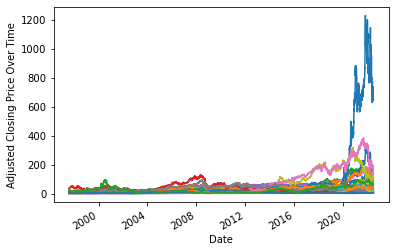

In [3]:
#defining time range
from datetime import datetime, timedelta
start =  datetime.today() - timedelta(weeks=52*25) #Last 25 years
end = datetime.today()
#print(start, end)

#grabbing stock data
stock_data = web.get_data_yahoo(symbols, start= start, end= end)
mcaps = web.get_quote_yahoo(symbols, start, end)['marketCap']
stock_data["Adj Close"].plot(ylabel="Adjusted Closing Price Over Time", legend = False)

In [4]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel
from pypfopt import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.discrete_allocation import get_latest_prices
from pypfopt.expected_returns import capm_return, mean_historical_return, ema_historical_return, returns_from_prices
from pypfopt import plotting
"""
market_prices is a series of S&P500 prices
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
"""
market_prices = stock_data["Adj Close"]
#cov_matrix = CovarianceShrinkage(market_prices).ledoit_wolf()
cov_matrix = risk_models.risk_matrix(market_prices, method='oracle_approximating')
mcaps = dict(mcaps)
#risk_free = market_prices["^TNX"]*0.01
risk_free = 0.0325
mu = capm_return(market_prices, risk_free_rate=risk_free)
#mu = mean_historical_return(market_prices)
#mu = ema_historical_return(market_prices)
#print( market_prices, cov_matrix, mcaps)

In [5]:
import seaborn as sns

def plot_black_litterman_results(ret_bl, covar_bl, market_prior, mu):
    rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(mu)],
    index = ["Prio", "Posterior", "Views"]).T
    rets_df.plot.bar(figsize=(12,8), title='Black-Litterman Expected Returns')
    plt.show()
    plt.clf()
    sns.heatmap(covar_bl)
    plt.title("bl covariance")
    plt.show()
    plt.clf()
    corr_bl = mh.cov2corr(covar_bl)
    corr_bl = pd.DataFrame(corr_bl, index=covar_bl.index, columns=covar_bl.columns)
    sns.heatmap(corr_bl)
    plt.title("bl correlation")
    plt.show()
    plt.clf()

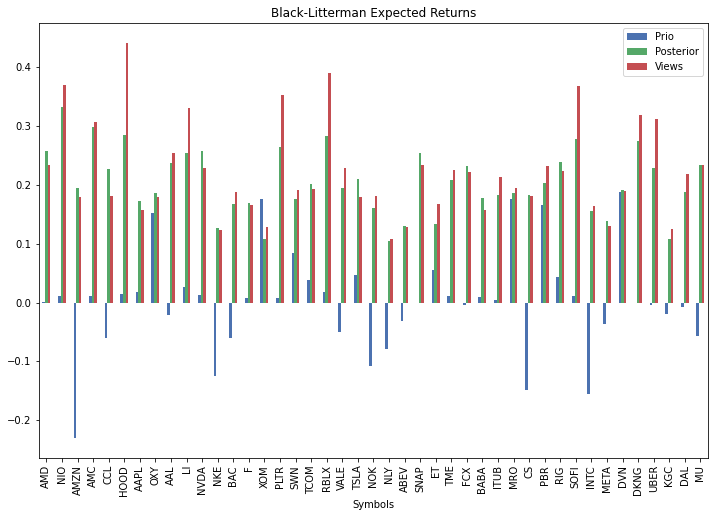

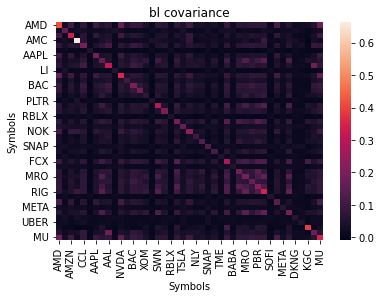

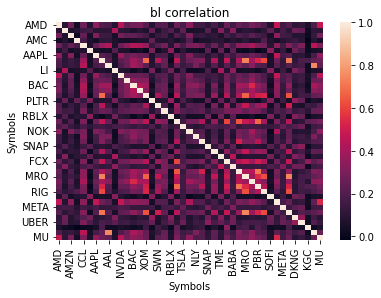

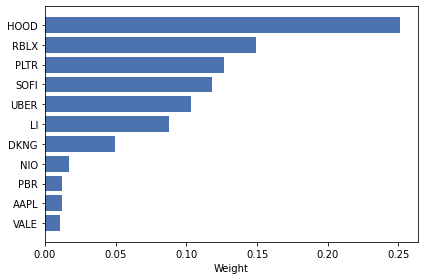

{'NIO': 0.01666, 'HOOD': 0.25096, 'AAPL': 0.01178, 'LI': 0.08744, 'PLTR': 0.12683, 'RBLX': 0.14925, 'VALE': 0.01057, 'PBR': 0.01189, 'SOFI': 0.11842, 'DKNG': 0.04978, 'UBER': 0.10327}
Expected annual return: 26.3%
Annual volatility: 13.3%
Sharpe Ratio: 1.83


In [6]:
import statsmodels.stats.moment_helpers as mh

def calc_omega(symbols):
    variances = []
    for symbol in sorted(symbols):
        view = symbol.median()
        lb, ub  = view[0], view[2]
        std_dev = (ub - lb)/2
        variances.append(std_dev ** 2)
    omega = np.diag(variances)
    return omega

def calc_black_litterman(market_prices, mcaps, cov_matrix, symbols):
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    #print(delta)
    market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)
    blmu = mu
    #omega = calc_omega(symbols)
    bl = BlackLittermanModel(cov_matrix, pi='market', market_caps = mcaps, absolute_views= blmu)#risk_aversion= delta
    rets_bl = bl.bl_returns()
    covar_bl = bl.bl_cov()
    plot_black_litterman_results(rets_bl, covar_bl, market_prior, mu)
    
    #return rets_bl, covar_bl

    ef = EfficientFrontier(rets_bl, covar_bl, weight_bounds= (0,1))
    ef.max_sharpe()
    weights = ef.clean_weights(0.01)
    weights = {x:y for x,y in weights.items() if y!=0}
    
    plt.clf()
    plotting.plot_weights(weights)
    plt.show()

    print(weights)
    ef.portfolio_performance(verbose=True)

    weights = pd.DataFrame.from_dict(weights, orient='index')
    weights.columns=['Max Sharpe']

calc_black_litterman(market_prices, mcaps, cov_matrix, symbols)

{'NIO': 0.01626, 'HOOD': 0.25558, 'LI': 0.08837, 'PLTR': 0.12808, 'RBLX': 0.1514, 'VALE': 0.01118, 'ITUB': 0.01082, 'PBR': 0.01207, 'SOFI': 0.11977, 'DKNG': 0.04981, 'UBER': 0.10445}
Expected annual return: 26.4%
Annual volatility: 13.3%
Sharpe Ratio: 1.84


C:\Users\Ben\AppData\Roaming\Python\Python39\site-packages\pypfopt\black_litterman.py:257: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


<AxesSubplot:xlabel='Weight'>

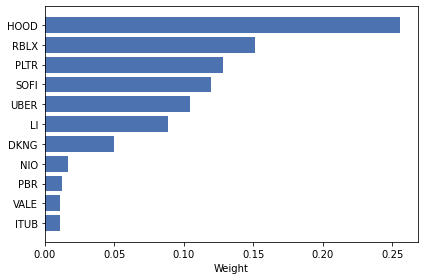

In [7]:
#Black Litterman Allocation

delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)
#print(delta, prior)

views =  pd.Series(capm_return(market_prices, risk_free_rate = risk_free))
#views = pd.Series(mean_historical_return(market_prices))
#views = pd.Series(ema_historical_return(market_prices))
#views = returns_from_prices(market_prices)
#print(views)
bl = BlackLittermanModel(cov_matrix= cov_matrix, absolute_views= views)

rets = bl.bl_returns()
efficient_frontier = EfficientFrontier(rets, cov_matrix)

weights = efficient_frontier.max_sharpe()
cleaned_weights = dict(efficient_frontier.clean_weights(0.01))
cleaned_weights = {x:y for x,y in cleaned_weights.items() if y!=0}
print(cleaned_weights)
efficient_frontier.portfolio_performance(verbose = True)

plotting.plot_weights(cleaned_weights)


C:\Users\Ben\AppData\Roaming\Python\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


{'HOOD': 0.34281, 'LI': 0.08849, 'XOM': 0.01126, 'PLTR': 0.12243, 'RBLX': 0.15041, 'VALE': 0.01021, 'ET': 0.01562, 'SOFI': 0.09707, 'UBER': 0.12698}
Expected annual return: 37.2%
Annual volatility: 13.4%
Sharpe Ratio: 2.63


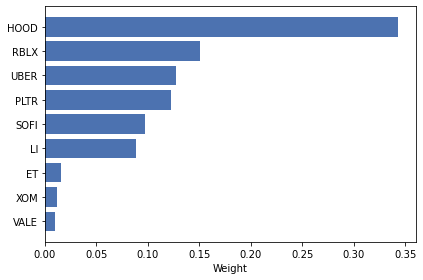

<Figure size 432x288 with 0 Axes>

In [8]:
#L2 regularisation
from pypfopt import objective_functions

efficient_frontier = EfficientFrontier(mu, cov_matrix, weight_bounds = (0, 1)) #, weight_bounds = (-1,1) #, solver = "ECOS_BB"
efficient_frontier.add_objective(objective_functions.L2_reg, gamma=0.0000000001)

w = efficient_frontier.max_sharpe()
cleaned_weights = dict(efficient_frontier.clean_weights(0.01))
cleaned_weights = {x:y for x,y in cleaned_weights.items() if y!=0}
print(cleaned_weights)

efficient_frontier.portfolio_performance(verbose = True)
plotting.plot_weights(cleaned_weights)
plt.show()
plt.clf()
#plot_frontier(efficient_frontier)


{'AMD': 0.01025, 'AMZN': 0.02318, 'CCL': 0.02527, 'AAPL': 0.03259, 'OXY': 0.02254, 'AAL': 0.01073, 'NVDA': 0.01588, 'NKE': 0.08002, 'BAC': 0.01785, 'F': 0.04822, 'XOM': 0.05165, 'SWN': 0.01499, 'TCOM': 0.02251, 'VALE': 0.01441, 'TSLA': 0.01645, 'NOK': 0.03598, 'NLY': 0.10663, 'ABEV': 0.04176, 'SNAP': 0.01493, 'ET': 0.02565, 'TME': 0.01056, 'FCX': 0.01192, 'BABA': 0.02211, 'ITUB': 0.02203, 'MRO': 0.02645, 'CS': 0.03605, 'PBR': 0.01797, 'RIG': 0.0176, 'INTC': 0.02685, 'META': 0.03725, 'DVN': 0.02217, 'DKNG': 0.01106, 'KGC': 0.02664, 'DAL': 0.01653, 'MU': 0.01148}
Expected annual return: 17.8%
Annual volatility: 24.8%
Sharpe Ratio: 0.64


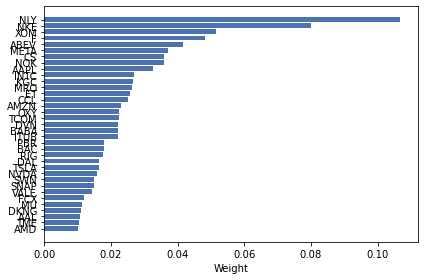

<AxesSubplot:>

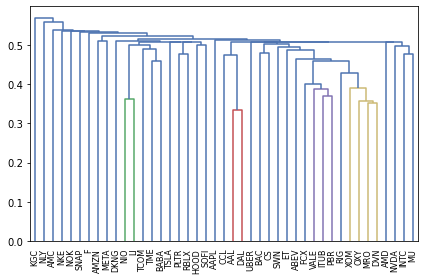

In [9]:
#Heirarchical Risk Parity

from pypfopt import HRPOpt

returns = market_prices.pct_change()
hrp = HRPOpt(returns)

hrp_weights = hrp.optimize()
#print(hrp.n_assets)
hrp_weights = hrp.clean_weights(0.01)
hrp_weights = {x:y for x,y in hrp_weights.items() if y!=0}
print(dict(hrp_weights))
hrp.portfolio_performance(verbose=True)

plotting.plot_weights(hrp_weights)
plt.show()
plt.clf()
plotting.plot_dendrogram(hrp)
